In [2]:
import time
from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_rows', 100)

In [3]:
df_incidents=pd.read_csv('data/incidents.csv', index_col=None)
df_incidents=df_incidents.loc[df_incidents['incidentType']!='varDecision']
df_incidents=df_incidents.loc[df_incidents['incidentType']!='injuryTime']
df_incidents=df_incidents.loc[df_incidents['time']>0]
df_incidents=df_incidents.loc[df_incidents['time']<91]
torem=['period','injuryTime']
df_incidents=df_incidents.loc[~(df_incidents['incidentType'].isin(torem))]
df_incidents.loc[(df_incidents['addedTime']>0) & (df_incidents['time']==90),'time']=90.5
df_incidents.loc[(df_incidents['addedTime']>0) & (df_incidents['time']==45),'time']=45.5

df_graph=pd.read_csv('data/graph.csv', index_col=None)
df_graph=df_graph.loc[df_graph['minute']>0]
df_graph=df_graph.loc[df_graph['minute']<91]
df_graph.columns=['mid','time','graph']
df_graph=df_graph.loc[df_graph['mid'].isin(df_incidents['mid'].unique())]
df=df_graph.merge(df_incidents[['mid','time','position1','incidentType','isHome']], on=['mid','time'], how='left')

df=pd.get_dummies(df, columns=['incidentType'], prefix=['it'] )
df=pd.get_dummies(df, columns=['position1'], prefix=['p'] )
df=pd.get_dummies(df, columns=['isHome'], prefix=['h'] )

df['h_goal']=df['it_goal']*df['h_True']
df['a_goal']=df['it_goal']*df['h_False']

df['h_red']=(df['it_red']+df['it_yellowRed'])*df['h_True']
df['a_red']=(df['it_red']+df['it_yellowRed'])*df['h_False']

df['h_yellow']=(df['it_yellow']+df['it_yellowRed'])*df['h_True']
df['a_yellow']=(df['it_yellow']+df['it_yellowRed'])*df['h_False']

df['h_penalty']=df['it_inGamePenalty']*df['h_True']
df['a_penalty']=df['it_inGamePenalty']*df['h_False']

df['h_subs']=df['it_substitution']*df['h_True']
df['a_subs']=df['it_substitution']*df['h_False']

df.drop(['it_yellowRed','it_inGamePenalty','it_substitution','it_yellow','it_red','it_goal','h_True','h_False'], axis = 1, inplace=True) 


In [4]:
df['h_goal_next']=df.groupby('mid')['h_goal'].apply(lambda x: x.shift(-1))
df['a_goal_next']=df.groupby('mid')['a_goal'].apply(lambda x: x.shift(-1))
df['graph3']=df.groupby('mid')['graph'].apply(lambda x: x.rolling(3, min_periods=1).sum())
df['hsc']=df.groupby('mid')['h_goal'].apply(lambda x: x.cumsum())
df['asc']=df.groupby('mid')['a_goal'].apply(lambda x: x.cumsum())
#df['g3']=df.groupby('mid')['graph'].apply(lambda x: x.shift(1).rolling(3, min_periods=1).sum())
df=df.fillna(0)

In [5]:
df.loc[df['mid']==8699223]

,mid,time,graph,p_D,p_F,p_G,p_M,h_goal,a_goal,h_red,...,a_yellow,h_penalty,a_penalty,h_subs,a_subs,h_goal_next,a_goal_next,graph3,hsc,asc
914172,8699223,1.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,2.0,0,0
914173,8699223,2.0,-49,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,-47.0,0,0
914174,8699223,3.0,-27,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,-74.0,0,0
914175,8699223,4.0,-10,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,-86.0,0,0
914176,8699223,5.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,-30.0,0,0
914177,8699223,6.0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,5.0,0,0
914178,8699223,7.0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,25.0,0,0
914179,8699223,8.0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,26.0,0,0
914180,8699223,9.0,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,39.0,0,0
914181,8699223,10.0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,38.0,0,0


In [6]:
df[['hsc','asc']]=df[['hsc','asc']].astype(float)
df['sc']=df['hsc']-df['asc']
df_home=df[['mid', 'time', 'graph', 'p_D', 'p_F', 'p_G', 'p_M', 'h_goal', 'a_goal',
       'h_red', 'a_red', 'h_yellow', 'a_yellow', 'h_penalty', 'a_penalty',
       'h_subs', 'a_subs', 'h_goal_next', 'graph3','sc']]
df_away=df[['mid', 'time', 'graph', 'p_D', 'p_F', 'p_G', 'p_M', 'h_goal', 'a_goal',
       'h_red', 'a_red', 'h_yellow', 'a_yellow', 'h_penalty', 'a_penalty',
       'h_subs', 'a_subs', 'a_goal_next', 'graph3','sc']]
df_away.columns=['mid', 'time', 'graph', 'p_D', 'p_F', 'p_G', 'p_M', 'a_goal', 'h_goal',
       'a_red', 'h_red', 'a_yellow', 'h_yellow', 'a_penalty', 'h_penalty',
       'a_subs', 'h_subs', 'h_goal_next', 'graph3','sc']
df_away['graph']=df_away['graph']*-1
df_away['graph3']=df_away['graph3']*-1
df_away['sc']=df_away['sc']*-1
df=pd.concat([df_home, df_away]).reset_index(drop=True)

In [7]:

cols_info=['mid', 'time']
cols_num=['graph', 'graph3', 'sc']
cols_bin=['p_D', 'p_F', 'p_G', 'p_M', 'h_goal', 'a_goal',
       'h_red', 'a_red', 'h_yellow', 'a_yellow', 'h_penalty', 'a_penalty',
       'h_subs', 'a_subs']
cols_out=[ 'h_goal_next']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df[cols_num].values)
df=pd.concat([pd.DataFrame(data=scaled, columns=cols_num), df[cols_info+cols_bin+cols_out]], axis=1)

In [8]:
mids=df.mid.unique()
np.random.shuffle(mids)
#train, test, validate = np.split(rids, [int(.7*len(rids)), int(.85*len(rids))]) 
train, test = np.split(mids, [int(.7*len(mids))]) 
# Split dataframe on parts
train_df=df[df['mid'].isin(train)]
test_df=df[df['mid'].isin(test)]
# split into input and outputs
train_X=train_df[train_df.columns[:-1]].values
train_y=train_df[train_df.columns[-1]].values
test_X=test_df[test_df.columns[:-1]].values
test_y=test_df[test_df.columns[-1]].values
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1280132, 1, 19) (1280132,) (548402, 1, 19) (548402,)


Epoch 1/50
17780/17780 - 43s - loss: 0.0155 - val_loss: 0.0153
Epoch 2/50
17780/17780 - 48s - loss: 0.0148 - val_loss: 0.0152
Epoch 3/50
17780/17780 - 52s - loss: 0.0148 - val_loss: 0.0153
Epoch 4/50
17780/17780 - 49s - loss: 0.0148 - val_loss: 0.0144
Epoch 5/50
17780/17780 - 50s - loss: 0.0148 - val_loss: 0.0143
Epoch 6/50
17780/17780 - 57s - loss: 0.0147 - val_loss: 0.0144
Epoch 7/50
17780/17780 - 61s - loss: 0.0147 - val_loss: 0.0143
Epoch 8/50
17780/17780 - 67s - loss: 0.0147 - val_loss: 0.0145
Epoch 9/50
17780/17780 - 66s - loss: 0.0147 - val_loss: 0.0147
Epoch 10/50
17780/17780 - 65s - loss: 0.0148 - val_loss: 0.0144
Epoch 11/50
17780/17780 - 66s - loss: 0.0147 - val_loss: 0.0151
Epoch 12/50
17780/17780 - 67s - loss: 0.0147 - val_loss: 0.0147
Epoch 13/50
17780/17780 - 67s - loss: 0.0147 - val_loss: 0.0147
Epoch 14/50
17780/17780 - 67s - loss: 0.0147 - val_loss: 0.0145
Epoch 15/50
17780/17780 - 66s - loss: 0.0148 - val_loss: 0.0150
Epoch 16/50
17780/17780 - 66s - loss: 0.0147 - va

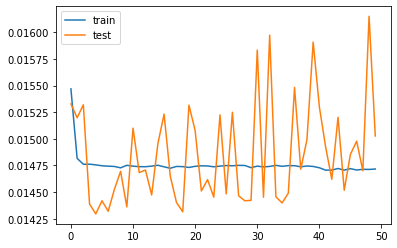

In [11]:
# design network
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=.5))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
df.loc[df['mid']==8699223]